In [43]:
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap
import optax
from diffrax import diffeqsolve, ODETerm, Dopri5

#### Stochastic interpolants example

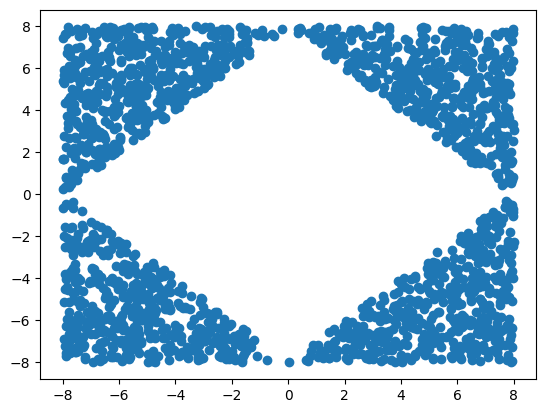

In [123]:
num_target = 2000
key = jax.random.PRNGKey(10)
target_samples = jax.random.uniform(key,shape = (10*num_target,2),minval=-1,maxval=1)
target_samples = 8 * target_samples[jnp.sum(jnp.abs(target_samples),1)>1.][:num_target]

plt.scatter(target_samples[:,0],target_samples[:,1])

In [124]:
num_reference = 2000
key = jax.random.PRNGKey(15)
reference_samples = jax.random.normal(key=key,shape=(num_reference,2))

In [125]:
class NeuralNetwork(eqx.Module):
    layers: list
    extra_bias: jax.Array

    def __init__(self, key):
        key1, key2, key3 = jax.random.split(key, 3)
        # These contain trainable parameters.
        self.layers = [eqx.nn.Linear(3, 512, key=key1),
                       jax.nn.elu,
                       eqx.nn.Linear(512, 512, key=key2),
                       jax.nn.elu,
                       eqx.nn.Linear(512, 2, key=key3)]
        # This is also a trainable parameter.
        self.extra_bias = jax.numpy.ones(2)

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x) + self.extra_bias
    
def I(t,x,y):
    return jnp.cos(t)*x + jnp.sin(t)*y

def It(t,x,y):
    return -jnp.sin(t)*x + jnp.cos(t)*y

def gamma(t):
    return jnp.sqrt(2*t*(1-t))

gammadot = vmap(vmap(grad(gamma)))

@eqx.filter_jit  # compile this function to make it run fast.
# @eqx.filter_grad  # differentiate all floating-point arrays in `model`.
def loss(model, t, x, y, z):
    tx = jnp.hstack([t.reshape(-1,1),I(t,x,y)])
    bhat = jax.vmap(model)(tx)  # vectorise the model over a batch of data


    bnorm2 = jnp.mean(jnp.sum(bhat**2,axis=1))
    dot_term = jnp.mean(jnp.sum((It(t,x,y) + gammadot(t)*z)*bhat,axis=1))
    dot_term = 2 * jnp.mean(jnp.sum((It(t,x,y))*bhat,axis=1))
    return bnorm2 - dot_term
    # return jnp.mean((bhat - (It(t,x,y) + gammadot(t)*z))**2)

In [126]:
t = jax.random.uniform(jax.random.PRNGKey(3),(num_target,1))
z = jax.random.normal(jax.random.PRNGKey(4),(num_target,2))
model = NeuralNetwork(jax.random.PRNGKey(0))
loss(model,t,reference_samples,target_samples,z)

Array(1.0195465, dtype=float32)

In [127]:
def evaluate(model, testloader):
    avg_loss = 0
    for t,x,y,z in testloader:
        avg_loss += loss(model,t,x,y,z)
    return avg_loss / 100

In [128]:
def get_trainloader(batch_size = 128):
    for i in range(10**6):
        trainloader_key = jax.random.PRNGKey(i)
        ref_key,target_key,normal_key,t_key = jax.random.split(trainloader_key,4)

        ref_batch = jax.random.choice(ref_key,reference_samples,(batch_size,))#jax.random.permutation(shuffle_ref_key,reference_samples)
        target_batch = jax.random.choice(target_key,target_samples,(batch_size,))
        #target_batch = jax.random.permutation(shuffle_target_key,target_samples)

        t_vals = jax.random.uniform(t_key,(batch_size,1))

        z = jax.random.normal(normal_key,ref_batch.shape)

        yield t_vals,ref_batch,target_batch,z

def get_testloader(batch_size = 1000):
    num_batches = 100
    for i in range(num_batches):
        testloader_key = jax.random.PRNGKey(1000*i)
        ref_key,target_key,normal_key,t_key = jax.random.split(testloader_key,4)

        ref_batch = jax.random.choice(ref_key,reference_samples,(batch_size,))
        target_batch = jax.random.choice(target_key,target_samples,(batch_size,))

        t_vals = jax.random.uniform(t_key,(batch_size,1))

        z = jax.random.normal(normal_key,ref_batch.shape)
        yield t_vals,ref_batch,target_batch,z

In [129]:
def train(
  model: NeuralNetwork,
  optim,
  steps,
  train_loader,
  print_every
)  -> NeuralNetwork:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model,
        opt_state,
        t,
        x,
        y,
        z
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model,t,x,y,z)
        updates, opt_state = optim.update(grads,opt_state,model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    train_losses = []
    
    for step, (t,x,y,z) in zip(range(steps), trainloader):
        model, opt_state, train_loss = make_step(model, opt_state, t,x,y,z)
        train_losses.append(train_loss)
        if jnp.isnan(train_loss):
            print("Nan")
            break
        if (step % print_every) == 0 or (step == steps - 1):
            testloader = get_testloader()
            test_loss = evaluate(model, testloader)
            print("step=" + str(step) + " | train_loss=" + str(train_loss) + " | test_loss= "+ str(test_loss))

    return model,train_losses
                

In [130]:
learning_rate = 1e-4

optim = optax.chain(
   optax.clip_by_global_norm(1.0),
   optax.adamw(learning_rate),
)
model = NeuralNetwork(jax.random.PRNGKey(420))
trainloader = get_trainloader(batch_size = 2048)

model,losses = train(model,optim,steps=10000,train_loader=trainloader,print_every=1000)

step=0 | train_loss=0.47026503 | test_loss= -1.0483835
step=1000 | train_loss=-32.085724 | test_loss= -31.76526
step=2000 | train_loss=-31.619867 | test_loss= -32.079746
step=3000 | train_loss=-31.75953 | test_loss= -32.18502
step=4000 | train_loss=-32.703598 | test_loss= -32.24086
step=5000 | train_loss=-32.09095 | test_loss= -32.27955
step=6000 | train_loss=-32.33329 | test_loss= -32.271034
step=7000 | train_loss=-32.306656 | test_loss= -32.30527
step=8000 | train_loss=-31.83939 | test_loss= -32.310883
step=9000 | train_loss=-33.10049 | test_loss= -32.327747
step=9999 | train_loss=-32.601063 | test_loss= -32.325844


In [131]:
vmapped_model = vmap(model)
def dX_t(t,x,args):
    t_vec = jnp.ones((len(x),1))*t
    return vmapped_model(jnp.hstack([t_vec,x]))

In [132]:
X0 = reference_samples.copy()
X = X0.copy()
X_hist = []
t = 0
for i in range(100):
    X += 0.01 * dX_t(t,X,None)
    t+=0.01
    X_hist.append(X)

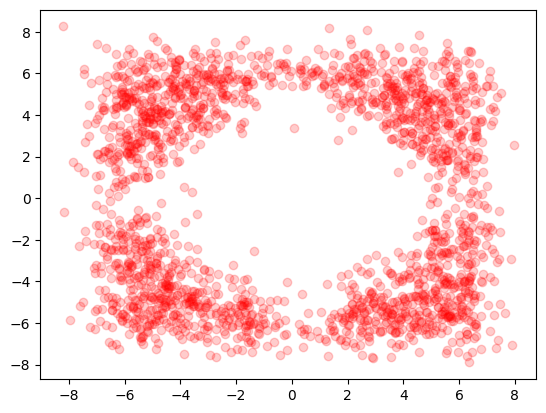

In [133]:
plt.scatter(X[:,0],X[:,1],c='red',alpha = 0.2)
#plt.scatter(target_samples[:,0],target_samples[:,1],c='black',alpha = 0.2)


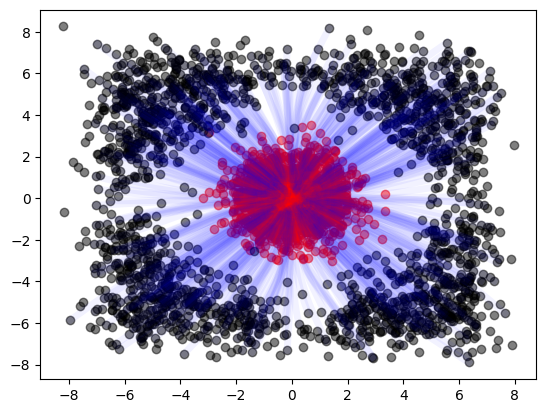

In [138]:
X_hist = jnp.array(X_hist)
plt.scatter(X0[:,0],X0[:,1],c='red',alpha = 0.5)
plt.scatter(X[:,0],X[:,1],c='black',alpha = 0.5)

for i in range(500):
    plt.plot(X_hist[:,i,0],X_hist[:,i,1],c='blue',alpha = 0.05,lw = 5)

In [119]:
term = ODETerm(dX_t)
solver = Dopri5()
X0 = reference_samples
solution = diffeqsolve(term, solver, t0=0, t1=1., dt0=0.01, y0=X0)

In [120]:
sol_samples = solution.ys[0]

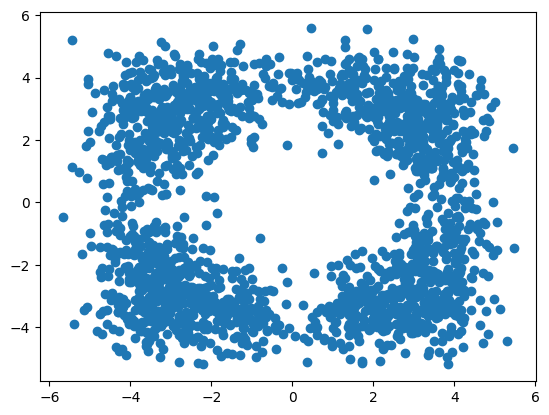

In [139]:
plt.scatter(sol_samples[:,0],sol_samples[:,1])

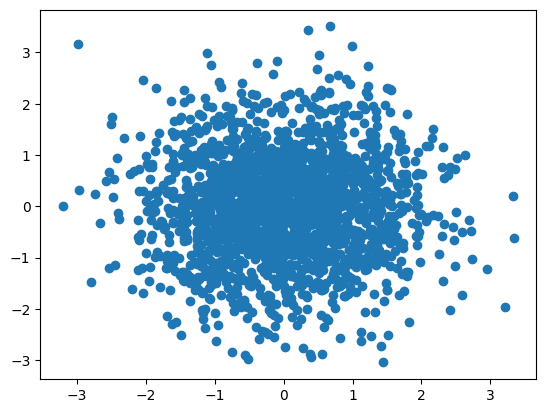

In [122]:
plt.scatter(X0[:,0],X0[:,1])